# Clorophyll - El Niño

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th
from ind_setup.plotting import plot_base_map, plot_map_subplots, add_oni_cat
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import download_ERDDAP_data, download_oni_index


Define area of interest

In [3]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [4]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

## Download Data

In [5]:
update_data = False
path_data = "../../../data"

In [6]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv'
dataset_id = 'chlor_a'
if update_data:
    date_ini = '1998-01-01T00:00:00Z'
    date_end = '2023-12-01T00:00:00Z'
    data = download_ERDDAP_data(base_url, dataset_id, date_ini, date_end, lon_range, lat_range)
    data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
    data_xr['time'] = pd.to_datetime(data_xr.time)
    data_xr = data_xr.coarsen(longitude=2, latitude=2, boundary = 'pad').mean()
    data_xr.to_netcdf(op.join(path_data, f'griddap_{dataset_id}.nc'))
else:
    data_xr = xr.open_dataset(op.join(path_data, f'griddap_{dataset_id}.nc'))

In [7]:
if update_data:
    p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

In [8]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [9]:
df1 = add_oni_cat(df1, lims = lims)
df1['ONI'] = df1['oni_cat']

In [10]:
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)

In [11]:
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))

In [12]:
data_oni = data_xr.groupby('ONI_cat').mean()

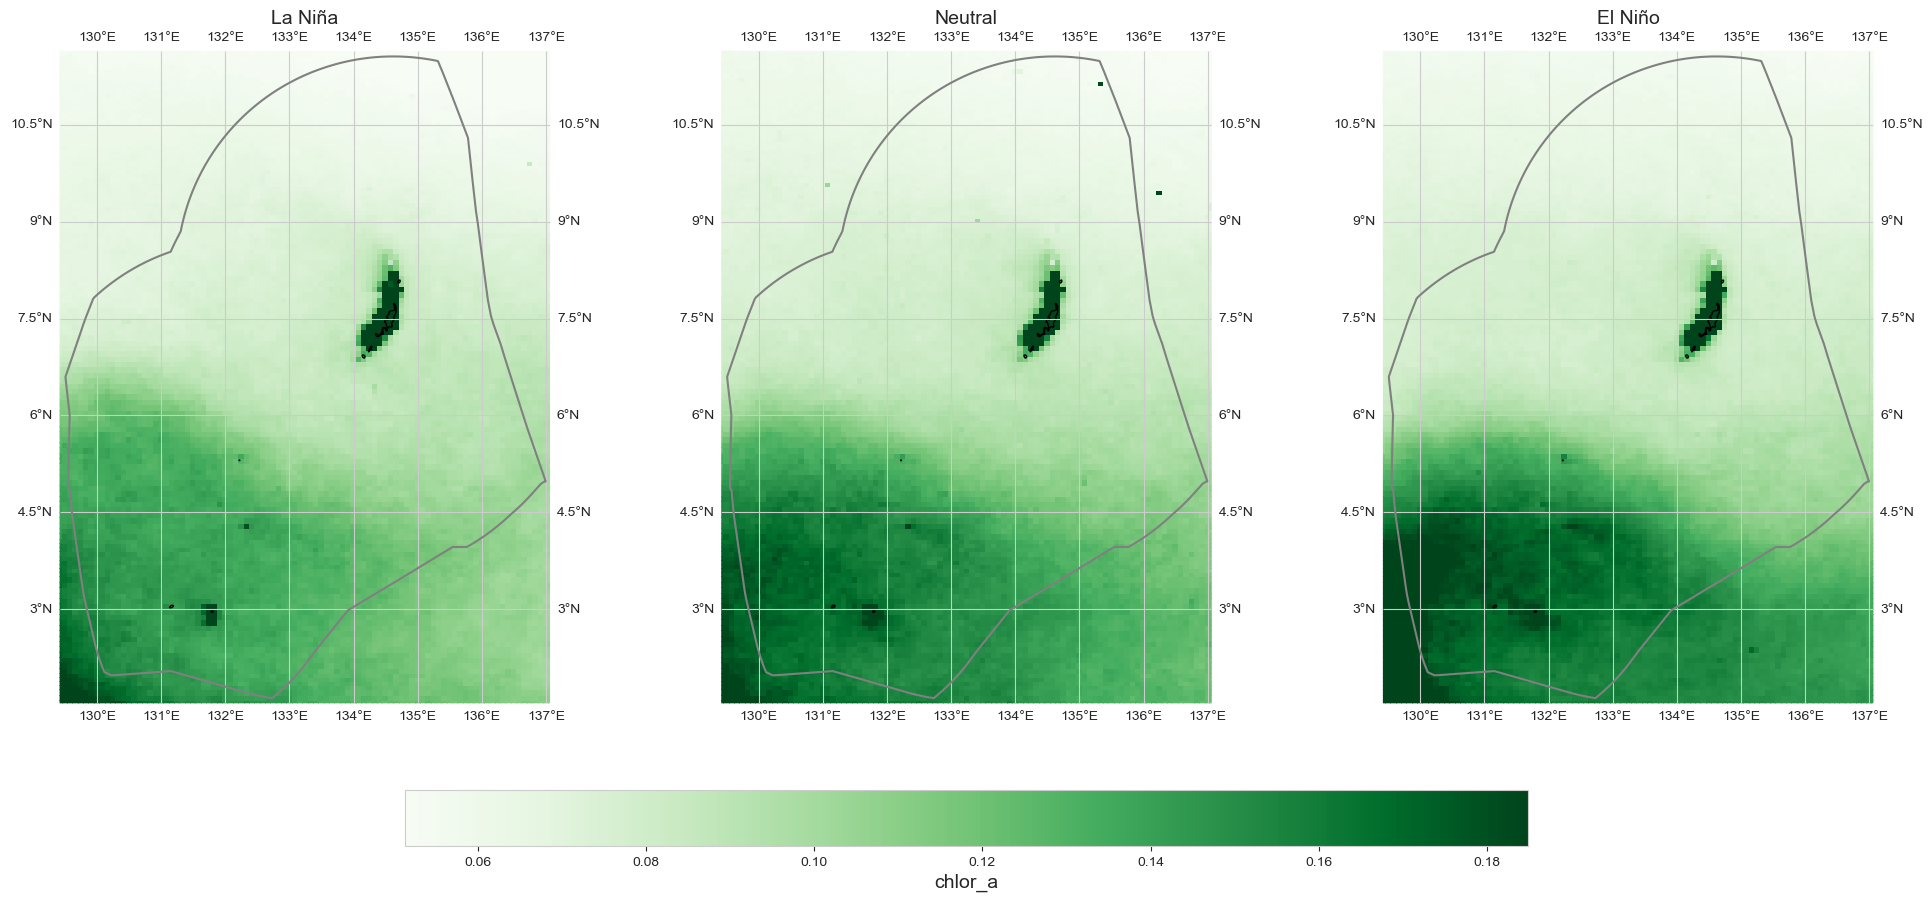

In [13]:
plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'Greens', 
                  vmin = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 1), 
                  vmax = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 99),
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)

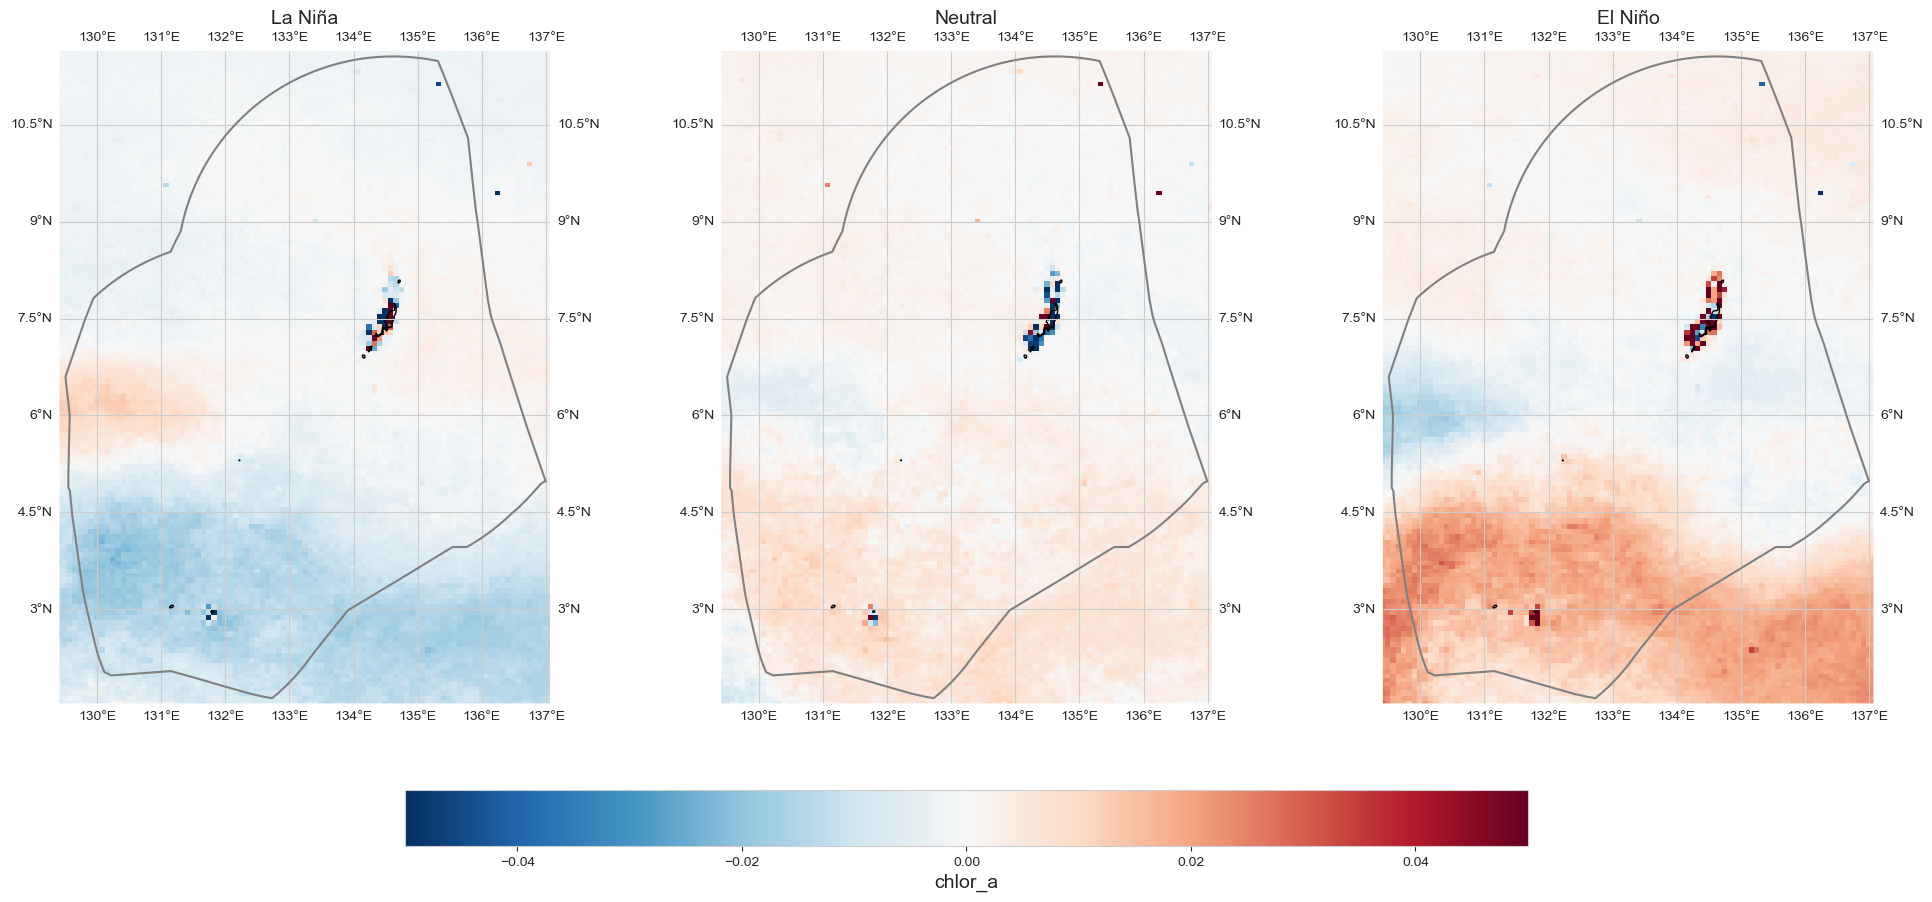

In [22]:
data_an = data_oni - data_xr.mean(dim='time')
plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.05, vmax=.05,
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)